# Trees and Forests

In this lab, we will explore classification in the context of tree-based models. Tree-based models can also be used for regression, but they are particularly popular for classification, especially given collections of categorical features. 

The basis of tree-based models is a sequence of rules, with the first decision rule at the top and subsequent rules at the bottom. Terminal nodes are sometimes called *leaves*. 

One reason that tree-based models are popular is that they are very easy to interpret. They can even be drawn/visualized, as we will see below.  In this lab, we'll explore a couple of features of tree-based models, including the ability to visualize the rules, as well as how to analyze feature importance.

We will use `DecisionTreeClassifier` and `RandomForestClassifier` as examples of trees and ensemble methods. If we were performing predictions based on continuous data, we would use the `Regressor` counterparts.

In [1]:
# Import Pandas and Numpy
import numpy as np
import pandas as pd

# Import Plotting Libraries
import matplotlib.pyplot as plt
%matplotlib inline

## Load and Process the Chicago Crime Data

We'll load the data, drop the small number of rows that have undefined values in features we care about, and create a feature, 'Hour', corresponding to hour of the day.

In [2]:
df = pd.read_csv("../../data/chicago-crimes-2019.csv.gz", compression='gzip')
print("Found {} NaN community area records.".format(df['Community Area'].isna().sum()))
df.dropna(inplace=True)
df['Hour'] = pd.to_datetime(df['Date']).dt.hour

Found 4 NaN community area records.


## Extract Features

Let's extract a few features that we want to work with.

In [3]:
df_backup = df.copy()
df = df.loc[:,['Hour', 'Community Area', 'Latitude', 'Longitude', 'Domestic', 'Arrest']]

## Decision Tree Classifiers

First, we will use the above features to fit a decision tree model.

### Training the Model

For the sake of making the initial visualization easy, let's start with just two features, and a decision tree with a max depth of three.

In [4]:
labels = df.loc[:,'Hour':'Community Area'].columns.values
features = df.loc[:,'Hour':'Community Area'].values
target = df['Arrest'].values

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0,max_depth=3)
model = dt.fit(features,target)

### Visualize the Resulting Model

Below is an example showing how the resulting decision tree can be visualized. We kept the number of features small above to make visualization quick. You may need to install some dependencies (pydotplus, plus the graphviz executable, to get this cell to run. 

To install graphviz on a Mac, for example, you can use a tool like Homebrew (e.g., `brew install graphviz`).

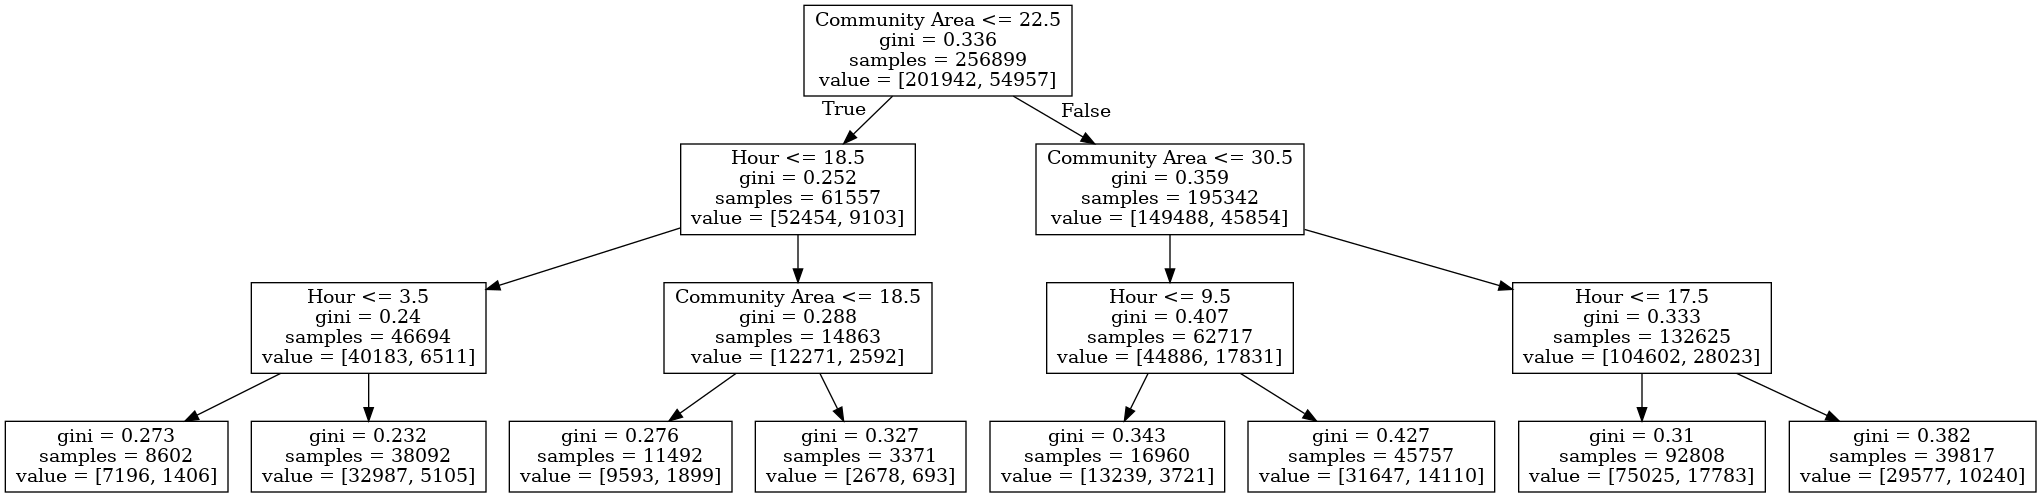

In [5]:
from sklearn import tree
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(dt, out_file=None, feature_names=labels)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Evaluate the Model

We can look at the accuracy of this simple model using a K-Fold cross validation and accuracy score.

In [6]:
from sklearn.model_selection import KFold, cross_val_score

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=23)

cv_results = cross_val_score(dt,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.786075456504014

Note that adding more features does not help that much.

In [7]:
# Include all features.
labels = df.loc[:,'Hour':'Domestic'].columns.values
features = df.loc[:,'Hour':'Domestic'].values

cv_results = cross_val_score(dt,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.7861338452093064

Increasing the maximum depth of the tree can improve accuracy slightly, but not overwhlmingly so. You can try removing the constraint as an exercise and note that accuracy actually *decreases*.

In [8]:
# Increase Depth

dt = DecisionTreeClassifier(random_state=0,max_depth=10)

cv_results = cross_val_score(dt,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.7919571460080758

## Random Forest Classifiers

Random forest improves on a decision tree classifier using an ensemble learning method called bagging. In a random forest, 
1. many decision trees are trained. Each tree receives a boostrapped sample of observations, and 
2. each node only considers a subset of the features when determining the best split.

The `balanced` mode, which we use below, uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
n_samples / (n_classes * np.bincount(y)).

In [9]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, 
                            n_jobs=-1, 
                            n_estimators=100,
                            class_weight='balanced'
                           )
model = rf.fit(features,target)

### Evaluating the Random Forest Classifier

Because bagging performs training on resampled models with replacement, it effectively performs the equivalent of cross-validation. We'll do a cross validation just for kicks, but it's statistically equivalent to do a train-test split and measure accuracy that way.

In [10]:
# Replace with train/test split.

cv_results = cross_val_score(rf,
                             features,
                             target,
                             cv=kf,
                             scoring='accuracy'
                            )
cv_results.mean()

0.7754565046200943

In [11]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.80, 
                                                    random_state=5) # 70% training and 30% test

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

# prediction on test set
y_pred=rf.predict(X_test)

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7771068509147528


### Exploring Feature Importance

One of the powerful aspects of a random forest classifier is that it is easy to plot and understand feature importance. The `feature_importances_` data structure maintains these relative feature importance values, which we can plot and visualize.

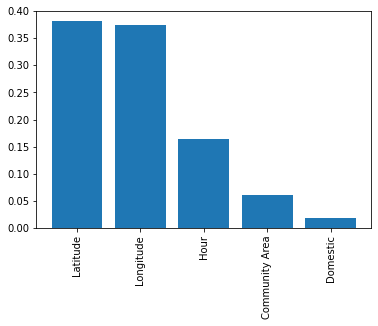

In [12]:
# Get feature importances
importances = model.feature_importances_

# Sort in descending order
indices = np.argsort(importances)[::-1]

# Sort the labels in a corresponding fashion
labels = df.loc[:,'Hour':'Domestic'].columns.values
names = [labels[i] for i in indices]

# Plot
plt.figure()
plt.bar(range(features.shape[1]),importances[indices])
plt.xticks(range(features.shape[1]), names, rotation=90)
plt.show()